In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_e_k5_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 92)
(734160, 1)
validation
(101248, 92)
(101248, 1)
test
(100432, 92)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 92)]              0         


 dense (Dense)               (None, 1024)              95232     


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 784385 (2.99 MB)


Trainable params: 784385 (2.99 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:23 - loss: 0.0800 - STD: 5.4403e-05 - MAE: 0.2727

 2/74 [..............................] - ETA: 41s - loss: 0.0601 - STD: 6.1489e-05 - MAE: 0.1756 

 8/74 [==>...........................] - ETA: 5s - loss: 0.0366 - STD: 6.7270e-05 - MAE: 0.1464 

14/74 [====>.........................] - ETA: 3s - loss: 0.0273 - STD: 9.9959e-05 - MAE: 0.1212

20/74 [=======>......................] - ETA: 2s - loss: 0.0237 - STD: 1.3445e-04 - MAE: 0.1152

26/74 [=========>....................] - ETA: 1s - loss: 0.0213 - STD: 1.5348e-04 - MAE: 0.1029

32/74 [===========>..................] - ETA: 1s - loss: 0.0196 - STD: 1.7678e-04 - MAE: 0.0960

38/74 [==============>...............] - ETA: 0s - loss: 0.0184 - STD: 2.0436e-04 - MAE: 0.0938

44/74 [================>.............] - ETA: 0s - loss: 0.0175 - STD: 2.2883e-04 - MAE: 0.0899

50/74 [===================>..........] - ETA: 0s - loss: 0.0169 - STD: 2.5625e-04 - MAE: 0.0870

56/74 [=====================>........] - ETA: 0s - loss: 0.0163 - STD: 2.8878e-04 - MAE: 0.0855

62/74 [========================>.....] - ETA: 0s - loss: 0.0159 - STD: 3.2374e-04 - MAE: 0.0838

68/74 [==========================>...] - ETA: 0s - loss: 0.0156 - STD: 3.6413e-04 - MAE: 0.0825

74/74 [==============================] - ETA: 0s - loss: 0.0152 - STD: 4.1139e-04 - MAE: 0.0815

74/74 [==============================] - 3s 24ms/step - loss: 0.0152 - STD: 4.1139e-04 - MAE: 0.0815 - val_loss: 0.0143 - val_STD: 8.5361e-04 - val_MAE: 0.0721


Epoch 2/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0117 - STD: 0.0010 - MAE: 0.0677

 7/74 [=>............................] - ETA: 0s - loss: 0.0116 - STD: 0.0012 - MAE: 0.0665

13/74 [====>.........................] - ETA: 0s - loss: 0.0116 - STD: 0.0013 - MAE: 0.0677

19/74 [======>.......................] - ETA: 0s - loss: 0.0117 - STD: 0.0015 - MAE: 0.0681

25/74 [=========>....................] - ETA: 0s - loss: 0.0117 - STD: 0.0017 - MAE: 0.0683

31/74 [===========>..................] - ETA: 0s - loss: 0.0117 - STD: 0.0020 - MAE: 0.0683

37/74 [==============>...............] - ETA: 0s - loss: 0.0117 - STD: 0.0023 - MAE: 0.0682

44/74 [================>.............] - ETA: 0s - loss: 0.0116 - STD: 0.0029 - MAE: 0.0680

50/74 [===================>..........] - ETA: 0s - loss: 0.0115 - STD: 0.0036 - MAE: 0.0677

56/74 [=====================>........] - ETA: 0s - loss: 0.0113 - STD: 0.0047 - MAE: 0.0672

62/74 [========================>.....] - ETA: 0s - loss: 0.0111 - STD: 0.0063 - MAE: 0.0666

69/74 [==========================>...] - ETA: 0s - loss: 0.0108 - STD: 0.0092 - MAE: 0.0654

74/74 [==============================] - 1s 10ms/step - loss: 0.0104 - STD: 0.0122 - MAE: 0.0643 - val_loss: 0.0060 - val_STD: 0.0517 - val_MAE: 0.0470


Epoch 3/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0051 - STD: 0.0657 - MAE: 0.0461

 7/74 [=>............................] - ETA: 0s - loss: 0.0048 - STD: 0.0747 - MAE: 0.0447

13/74 [====>.........................] - ETA: 0s - loss: 0.0045 - STD: 0.0810 - MAE: 0.0434

19/74 [======>.......................] - ETA: 0s - loss: 0.0044 - STD: 0.0835 - MAE: 0.0423

25/74 [=========>....................] - ETA: 0s - loss: 0.0042 - STD: 0.0843 - MAE: 0.0415

31/74 [===========>..................] - ETA: 0s - loss: 0.0041 - STD: 0.0853 - MAE: 0.0409

37/74 [==============>...............] - ETA: 0s - loss: 0.0041 - STD: 0.0867 - MAE: 0.0404

43/74 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.0874 - MAE: 0.0400

50/74 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0879 - MAE: 0.0396

56/74 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0882 - MAE: 0.0394

62/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0886 - MAE: 0.0392

68/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0890 - MAE: 0.0390

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0894 - MAE: 0.0388

74/74 [==============================] - 1s 10ms/step - loss: 0.0037 - STD: 0.0894 - MAE: 0.0388 - val_loss: 0.0036 - val_STD: 0.0731 - val_MAE: 0.0389


Epoch 4/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0032 - STD: 0.0928 - MAE: 0.0375

 7/74 [=>............................] - ETA: 0s - loss: 0.0031 - STD: 0.0934 - MAE: 0.0368

13/74 [====>.........................] - ETA: 0s - loss: 0.0032 - STD: 0.0933 - MAE: 0.0369

19/74 [======>.......................] - ETA: 0s - loss: 0.0031 - STD: 0.0935 - MAE: 0.0368

25/74 [=========>....................] - ETA: 0s - loss: 0.0031 - STD: 0.0937 - MAE: 0.0368

31/74 [===========>..................] - ETA: 0s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0368

37/74 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0368

43/74 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0935 - MAE: 0.0368

49/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0937 - MAE: 0.0368

55/74 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0368

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0939 - MAE: 0.0367

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0367

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0367

74/74 [==============================] - 1s 10ms/step - loss: 0.0031 - STD: 0.0938 - MAE: 0.0367 - val_loss: 0.0035 - val_STD: 0.0745 - val_MAE: 0.0384


Epoch 5/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0031 - STD: 0.0928 - MAE: 0.0363

 7/74 [=>............................] - ETA: 0s - loss: 0.0031 - STD: 0.0935 - MAE: 0.0362

14/74 [====>.........................] - ETA: 0s - loss: 0.0031 - STD: 0.0932 - MAE: 0.0362

21/74 [=======>......................] - ETA: 0s - loss: 0.0031 - STD: 0.0936 - MAE: 0.0361

28/74 [==========>...................] - ETA: 0s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0361

35/74 [=============>................] - ETA: 0s - loss: 0.0031 - STD: 0.0939 - MAE: 0.0361

41/74 [===============>..............] - ETA: 0s - loss: 0.0031 - STD: 0.0940 - MAE: 0.0362

48/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0942 - MAE: 0.0362

55/74 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0943 - MAE: 0.0362

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0943 - MAE: 0.0362

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0943 - MAE: 0.0362

74/74 [==============================] - 1s 9ms/step - loss: 0.0031 - STD: 0.0942 - MAE: 0.0361 - val_loss: 0.0035 - val_STD: 0.0750 - val_MAE: 0.0383


Epoch 6/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0031 - STD: 0.0953 - MAE: 0.0360

 7/74 [=>............................] - ETA: 0s - loss: 0.0030 - STD: 0.0930 - MAE: 0.0358

13/74 [====>.........................] - ETA: 0s - loss: 0.0030 - STD: 0.0939 - MAE: 0.0357

19/74 [======>.......................] - ETA: 0s - loss: 0.0030 - STD: 0.0939 - MAE: 0.0358

25/74 [=========>....................] - ETA: 0s - loss: 0.0030 - STD: 0.0941 - MAE: 0.0358

31/74 [===========>..................] - ETA: 0s - loss: 0.0030 - STD: 0.0944 - MAE: 0.0359

37/74 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0943 - MAE: 0.0359

43/74 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0942 - MAE: 0.0359

49/74 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0944 - MAE: 0.0358

56/74 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0944 - MAE: 0.0358

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0945 - MAE: 0.0358

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0945 - MAE: 0.0358

74/74 [==============================] - 1s 9ms/step - loss: 0.0030 - STD: 0.0945 - MAE: 0.0358 - val_loss: 0.0035 - val_STD: 0.0762 - val_MAE: 0.0387


Epoch 7/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0029 - STD: 0.0928 - MAE: 0.0354

 7/74 [=>............................] - ETA: 0s - loss: 0.0030 - STD: 0.0941 - MAE: 0.0356

13/74 [====>.........................] - ETA: 0s - loss: 0.0030 - STD: 0.0945 - MAE: 0.0356

19/74 [======>.......................] - ETA: 0s - loss: 0.0030 - STD: 0.0942 - MAE: 0.0356

25/74 [=========>....................] - ETA: 0s - loss: 0.0030 - STD: 0.0943 - MAE: 0.0355

31/74 [===========>..................] - ETA: 0s - loss: 0.0030 - STD: 0.0946 - MAE: 0.0355

37/74 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0945 - MAE: 0.0355

43/74 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0946 - MAE: 0.0355

49/74 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0946 - MAE: 0.0355

55/74 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0946 - MAE: 0.0355

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0947 - MAE: 0.0355

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0947 - MAE: 0.0355

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0947 - MAE: 0.0355

74/74 [==============================] - 1s 10ms/step - loss: 0.0030 - STD: 0.0947 - MAE: 0.0355 - val_loss: 0.0034 - val_STD: 0.0778 - val_MAE: 0.0369


Epoch 8/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0030 - STD: 0.0945 - MAE: 0.0354

 7/74 [=>............................] - ETA: 0s - loss: 0.0030 - STD: 0.0958 - MAE: 0.0355

14/74 [====>.........................] - ETA: 0s - loss: 0.0030 - STD: 0.0953 - MAE: 0.0354

20/74 [=======>......................] - ETA: 0s - loss: 0.0030 - STD: 0.0957 - MAE: 0.0354

26/74 [=========>....................] - ETA: 0s - loss: 0.0030 - STD: 0.0956 - MAE: 0.0354

32/74 [===========>..................] - ETA: 0s - loss: 0.0030 - STD: 0.0953 - MAE: 0.0354

38/74 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0954 - MAE: 0.0354

44/74 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0952 - MAE: 0.0353

50/74 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0951 - MAE: 0.0353

57/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0949 - MAE: 0.0353

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0951 - MAE: 0.0353

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0951 - MAE: 0.0353

74/74 [==============================] - 1s 10ms/step - loss: 0.0029 - STD: 0.0950 - MAE: 0.0353 - val_loss: 0.0033 - val_STD: 0.0764 - val_MAE: 0.0364


Epoch 9/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0029 - STD: 0.0941 - MAE: 0.0346

 7/74 [=>............................] - ETA: 0s - loss: 0.0030 - STD: 0.0955 - MAE: 0.0353

13/74 [====>.........................] - ETA: 0s - loss: 0.0030 - STD: 0.0951 - MAE: 0.0353

19/74 [======>.......................] - ETA: 0s - loss: 0.0029 - STD: 0.0953 - MAE: 0.0353

26/74 [=========>....................] - ETA: 0s - loss: 0.0029 - STD: 0.0947 - MAE: 0.0352

33/74 [============>.................] - ETA: 0s - loss: 0.0029 - STD: 0.0949 - MAE: 0.0352

40/74 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.0947 - MAE: 0.0351

46/74 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0950 - MAE: 0.0351

52/74 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0950 - MAE: 0.0351

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0951 - MAE: 0.0351

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0951 - MAE: 0.0351

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0951 - MAE: 0.0351

74/74 [==============================] - 1s 10ms/step - loss: 0.0029 - STD: 0.0952 - MAE: 0.0351 - val_loss: 0.0033 - val_STD: 0.0772 - val_MAE: 0.0355


Epoch 10/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0029 - STD: 0.0958 - MAE: 0.0352

 7/74 [=>............................] - ETA: 0s - loss: 0.0029 - STD: 0.0960 - MAE: 0.0349

13/74 [====>.........................] - ETA: 0s - loss: 0.0029 - STD: 0.0954 - MAE: 0.0350

19/74 [======>.......................] - ETA: 0s - loss: 0.0029 - STD: 0.0954 - MAE: 0.0350

25/74 [=========>....................] - ETA: 0s - loss: 0.0029 - STD: 0.0955 - MAE: 0.0350

31/74 [===========>..................] - ETA: 0s - loss: 0.0029 - STD: 0.0953 - MAE: 0.0350

37/74 [==============>...............] - ETA: 0s - loss: 0.0029 - STD: 0.0955 - MAE: 0.0350

43/74 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0956 - MAE: 0.0350

49/74 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0957 - MAE: 0.0350

56/74 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0956 - MAE: 0.0350

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0955 - MAE: 0.0349

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0955 - MAE: 0.0349

74/74 [==============================] - 1s 10ms/step - loss: 0.0029 - STD: 0.0953 - MAE: 0.0349 - val_loss: 0.0032 - val_STD: 0.0769 - val_MAE: 0.0353


Epoch 11/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0030 - STD: 0.0953 - MAE: 0.0355

 7/74 [=>............................] - ETA: 0s - loss: 0.0029 - STD: 0.0947 - MAE: 0.0351

14/74 [====>.........................] - ETA: 0s - loss: 0.0029 - STD: 0.0950 - MAE: 0.0350

21/74 [=======>......................] - ETA: 0s - loss: 0.0029 - STD: 0.0949 - MAE: 0.0348

28/74 [==========>...................] - ETA: 0s - loss: 0.0029 - STD: 0.0948 - MAE: 0.0348

34/74 [============>.................] - ETA: 0s - loss: 0.0029 - STD: 0.0952 - MAE: 0.0347

40/74 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.0954 - MAE: 0.0348

46/74 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0955 - MAE: 0.0347

52/74 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0954 - MAE: 0.0347

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0956 - MAE: 0.0347

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0955 - MAE: 0.0348

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0955 - MAE: 0.0348

74/74 [==============================] - 1s 10ms/step - loss: 0.0029 - STD: 0.0955 - MAE: 0.0348 - val_loss: 0.0033 - val_STD: 0.0765 - val_MAE: 0.0360


Epoch 12/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0030 - STD: 0.0950 - MAE: 0.0352

 7/74 [=>............................] - ETA: 0s - loss: 0.0028 - STD: 0.0953 - MAE: 0.0346

13/74 [====>.........................] - ETA: 0s - loss: 0.0028 - STD: 0.0953 - MAE: 0.0347

19/74 [======>.......................] - ETA: 0s - loss: 0.0028 - STD: 0.0952 - MAE: 0.0346

25/74 [=========>....................] - ETA: 0s - loss: 0.0028 - STD: 0.0952 - MAE: 0.0346

31/74 [===========>..................] - ETA: 0s - loss: 0.0028 - STD: 0.0954 - MAE: 0.0346

37/74 [==============>...............] - ETA: 0s - loss: 0.0029 - STD: 0.0958 - MAE: 0.0347

44/74 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0956 - MAE: 0.0347

50/74 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0957 - MAE: 0.0347

56/74 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0958 - MAE: 0.0347

63/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0956 - MAE: 0.0347

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0956 - MAE: 0.0347

74/74 [==============================] - 1s 10ms/step - loss: 0.0029 - STD: 0.0955 - MAE: 0.0347 - val_loss: 0.0032 - val_STD: 0.0770 - val_MAE: 0.0358


Epoch 13/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0028 - STD: 0.0982 - MAE: 0.0344

 8/74 [==>...........................] - ETA: 0s - loss: 0.0028 - STD: 0.0970 - MAE: 0.0347

14/74 [====>.........................] - ETA: 0s - loss: 0.0028 - STD: 0.0959 - MAE: 0.0346

20/74 [=======>......................] - ETA: 0s - loss: 0.0028 - STD: 0.0961 - MAE: 0.0347

26/74 [=========>....................] - ETA: 0s - loss: 0.0028 - STD: 0.0957 - MAE: 0.0348

32/74 [===========>..................] - ETA: 0s - loss: 0.0028 - STD: 0.0956 - MAE: 0.0347

39/74 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.0957 - MAE: 0.0347

45/74 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0958 - MAE: 0.0347

51/74 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0960 - MAE: 0.0347

57/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0958 - MAE: 0.0347

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0958 - MAE: 0.0347

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0958 - MAE: 0.0347

74/74 [==============================] - 1s 9ms/step - loss: 0.0028 - STD: 0.0957 - MAE: 0.0347 - val_loss: 0.0033 - val_STD: 0.0789 - val_MAE: 0.0365


Epoch 14/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0029 - STD: 0.0981 - MAE: 0.0348

 7/74 [=>............................] - ETA: 0s - loss: 0.0028 - STD: 0.0948 - MAE: 0.0344

13/74 [====>.........................] - ETA: 0s - loss: 0.0028 - STD: 0.0952 - MAE: 0.0344

19/74 [======>.......................] - ETA: 0s - loss: 0.0028 - STD: 0.0953 - MAE: 0.0345

26/74 [=========>....................] - ETA: 0s - loss: 0.0028 - STD: 0.0953 - MAE: 0.0345

32/74 [===========>..................] - ETA: 0s - loss: 0.0028 - STD: 0.0956 - MAE: 0.0345

38/74 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.0956 - MAE: 0.0345

44/74 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0955 - MAE: 0.0345

50/74 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0957 - MAE: 0.0346

57/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0955 - MAE: 0.0346

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0957 - MAE: 0.0346

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0958 - MAE: 0.0346

74/74 [==============================] - 1s 10ms/step - loss: 0.0028 - STD: 0.0958 - MAE: 0.0346 - val_loss: 0.0032 - val_STD: 0.0766 - val_MAE: 0.0348


Epoch 15/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0027 - STD: 0.0955 - MAE: 0.0338

 7/74 [=>............................] - ETA: 0s - loss: 0.0028 - STD: 0.0959 - MAE: 0.0344

13/74 [====>.........................] - ETA: 0s - loss: 0.0028 - STD: 0.0957 - MAE: 0.0346

19/74 [======>.......................] - ETA: 0s - loss: 0.0028 - STD: 0.0959 - MAE: 0.0345

25/74 [=========>....................] - ETA: 0s - loss: 0.0028 - STD: 0.0958 - MAE: 0.0346

31/74 [===========>..................] - ETA: 0s - loss: 0.0028 - STD: 0.0959 - MAE: 0.0345

38/74 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.0958 - MAE: 0.0346

45/74 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0957 - MAE: 0.0346

52/74 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0958 - MAE: 0.0346

59/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0958 - MAE: 0.0345

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0958 - MAE: 0.0345

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0958 - MAE: 0.0345

74/74 [==============================] - 1s 9ms/step - loss: 0.0028 - STD: 0.0958 - MAE: 0.0345 - val_loss: 0.0032 - val_STD: 0.0781 - val_MAE: 0.0353


Epoch 16/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0028 - STD: 0.0953 - MAE: 0.0345

 7/74 [=>............................] - ETA: 0s - loss: 0.0028 - STD: 0.0960 - MAE: 0.0347

13/74 [====>.........................] - ETA: 0s - loss: 0.0028 - STD: 0.0960 - MAE: 0.0346

20/74 [=======>......................] - ETA: 0s - loss: 0.0028 - STD: 0.0963 - MAE: 0.0346

26/74 [=========>....................] - ETA: 0s - loss: 0.0028 - STD: 0.0960 - MAE: 0.0346

32/74 [===========>..................] - ETA: 0s - loss: 0.0028 - STD: 0.0960 - MAE: 0.0346

39/74 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.0960 - MAE: 0.0346

45/74 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0961 - MAE: 0.0345

51/74 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0962 - MAE: 0.0345

57/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0962 - MAE: 0.0346

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0961 - MAE: 0.0345

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0960 - MAE: 0.0345

74/74 [==============================] - 1s 10ms/step - loss: 0.0028 - STD: 0.0959 - MAE: 0.0345 - val_loss: 0.0032 - val_STD: 0.0775 - val_MAE: 0.0352


Epoch 17/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0028 - STD: 0.0947 - MAE: 0.0343

 7/74 [=>............................] - ETA: 0s - loss: 0.0028 - STD: 0.0958 - MAE: 0.0342

13/74 [====>.........................] - ETA: 0s - loss: 0.0028 - STD: 0.0959 - MAE: 0.0343

20/74 [=======>......................] - ETA: 0s - loss: 0.0028 - STD: 0.0956 - MAE: 0.0345

26/74 [=========>....................] - ETA: 0s - loss: 0.0028 - STD: 0.0958 - MAE: 0.0346

33/74 [============>.................] - ETA: 0s - loss: 0.0028 - STD: 0.0957 - MAE: 0.0346

39/74 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.0959 - MAE: 0.0346

45/74 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0956 - MAE: 0.0346

51/74 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0959 - MAE: 0.0346

57/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0958 - MAE: 0.0346

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0959 - MAE: 0.0346

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0958 - MAE: 0.0346

74/74 [==============================] - 1s 9ms/step - loss: 0.0028 - STD: 0.0958 - MAE: 0.0346 - val_loss: 0.0032 - val_STD: 0.0790 - val_MAE: 0.0358


Epoch 18/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0028 - STD: 0.0974 - MAE: 0.0344

 7/74 [=>............................] - ETA: 0s - loss: 0.0028 - STD: 0.0969 - MAE: 0.0343

13/74 [====>.........................] - ETA: 0s - loss: 0.0028 - STD: 0.0961 - MAE: 0.0343

20/74 [=======>......................] - ETA: 0s - loss: 0.0028 - STD: 0.0966 - MAE: 0.0342

26/74 [=========>....................] - ETA: 0s - loss: 0.0028 - STD: 0.0963 - MAE: 0.0343

32/74 [===========>..................] - ETA: 0s - loss: 0.0028 - STD: 0.0963 - MAE: 0.0344

38/74 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.0960 - MAE: 0.0344

44/74 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0958 - MAE: 0.0344

50/74 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0959 - MAE: 0.0344

57/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0959 - MAE: 0.0345

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0959 - MAE: 0.0345

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0959 - MAE: 0.0345

74/74 [==============================] - 1s 10ms/step - loss: 0.0028 - STD: 0.0960 - MAE: 0.0345 - val_loss: 0.0032 - val_STD: 0.0785 - val_MAE: 0.0357


Epoch 19/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0028 - STD: 0.0941 - MAE: 0.0342

 7/74 [=>............................] - ETA: 0s - loss: 0.0028 - STD: 0.0953 - MAE: 0.0345

14/74 [====>.........................] - ETA: 0s - loss: 0.0028 - STD: 0.0960 - MAE: 0.0344

20/74 [=======>......................] - ETA: 0s - loss: 0.0028 - STD: 0.0959 - MAE: 0.0343

26/74 [=========>....................] - ETA: 0s - loss: 0.0028 - STD: 0.0958 - MAE: 0.0343

32/74 [===========>..................] - ETA: 0s - loss: 0.0028 - STD: 0.0959 - MAE: 0.0343

39/74 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.0960 - MAE: 0.0344

45/74 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0960 - MAE: 0.0344

51/74 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0960 - MAE: 0.0344

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0960 - MAE: 0.0344

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0959 - MAE: 0.0344

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0959 - MAE: 0.0345

74/74 [==============================] - 1s 9ms/step - loss: 0.0028 - STD: 0.0960 - MAE: 0.0345 - val_loss: 0.0031 - val_STD: 0.0771 - val_MAE: 0.0346


Epoch 20/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0028 - STD: 0.0929 - MAE: 0.0342

 8/74 [==>...........................] - ETA: 0s - loss: 0.0028 - STD: 0.0943 - MAE: 0.0345

15/74 [=====>........................] - ETA: 0s - loss: 0.0028 - STD: 0.0959 - MAE: 0.0344

22/74 [=======>......................] - ETA: 0s - loss: 0.0028 - STD: 0.0958 - MAE: 0.0345

28/74 [==========>...................] - ETA: 0s - loss: 0.0028 - STD: 0.0960 - MAE: 0.0344

34/74 [============>.................] - ETA: 0s - loss: 0.0028 - STD: 0.0960 - MAE: 0.0345

40/74 [===============>..............] - ETA: 0s - loss: 0.0028 - STD: 0.0959 - MAE: 0.0345

46/74 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0960 - MAE: 0.0345

52/74 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0959 - MAE: 0.0345

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0959 - MAE: 0.0345

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0958 - MAE: 0.0344

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0959 - MAE: 0.0345

74/74 [==============================] - 1s 9ms/step - loss: 0.0028 - STD: 0.0959 - MAE: 0.0344 - val_loss: 0.0032 - val_STD: 0.0776 - val_MAE: 0.0353


Epoch 21/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0029 - STD: 0.0973 - MAE: 0.0341

 7/74 [=>............................] - ETA: 0s - loss: 0.0029 - STD: 0.0963 - MAE: 0.0347

14/74 [====>.........................] - ETA: 0s - loss: 0.0028 - STD: 0.0960 - MAE: 0.0346

20/74 [=======>......................] - ETA: 0s - loss: 0.0028 - STD: 0.0959 - MAE: 0.0345

27/74 [=========>....................] - ETA: 0s - loss: 0.0028 - STD: 0.0959 - MAE: 0.0344

33/74 [============>.................] - ETA: 0s - loss: 0.0028 - STD: 0.0960 - MAE: 0.0344

40/74 [===============>..............] - ETA: 0s - loss: 0.0028 - STD: 0.0958 - MAE: 0.0344

46/74 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0959 - MAE: 0.0344

52/74 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0959 - MAE: 0.0344

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0960 - MAE: 0.0343

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0961 - MAE: 0.0344

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0960 - MAE: 0.0343

74/74 [==============================] - 1s 9ms/step - loss: 0.0028 - STD: 0.0960 - MAE: 0.0344 - val_loss: 0.0032 - val_STD: 0.0786 - val_MAE: 0.0353


Epoch 22/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0026 - STD: 0.0965 - MAE: 0.0338

 7/74 [=>............................] - ETA: 0s - loss: 0.0027 - STD: 0.0973 - MAE: 0.0343

13/74 [====>.........................] - ETA: 0s - loss: 0.0028 - STD: 0.0964 - MAE: 0.0343

19/74 [======>.......................] - ETA: 0s - loss: 0.0028 - STD: 0.0960 - MAE: 0.0343

26/74 [=========>....................] - ETA: 0s - loss: 0.0028 - STD: 0.0964 - MAE: 0.0344

32/74 [===========>..................] - ETA: 0s - loss: 0.0028 - STD: 0.0962 - MAE: 0.0343

38/74 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.0962 - MAE: 0.0344

45/74 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0962 - MAE: 0.0344

51/74 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0962 - MAE: 0.0344

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0961 - MAE: 0.0344

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0960 - MAE: 0.0344

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0960 - MAE: 0.0344

74/74 [==============================] - 1s 9ms/step - loss: 0.0028 - STD: 0.0960 - MAE: 0.0344 - val_loss: 0.0033 - val_STD: 0.0789 - val_MAE: 0.0366


Epoch 23/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0029 - STD: 0.0972 - MAE: 0.0353

 7/74 [=>............................] - ETA: 0s - loss: 0.0029 - STD: 0.0961 - MAE: 0.0349

13/74 [====>.........................] - ETA: 0s - loss: 0.0028 - STD: 0.0956 - MAE: 0.0346

19/74 [======>.......................] - ETA: 0s - loss: 0.0028 - STD: 0.0959 - MAE: 0.0345

25/74 [=========>....................] - ETA: 0s - loss: 0.0028 - STD: 0.0957 - MAE: 0.0344

31/74 [===========>..................] - ETA: 0s - loss: 0.0028 - STD: 0.0957 - MAE: 0.0344

37/74 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.0958 - MAE: 0.0344

43/74 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0958 - MAE: 0.0344

50/74 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0958 - MAE: 0.0343

57/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0957 - MAE: 0.0343

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0959 - MAE: 0.0343

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0959 - MAE: 0.0343

74/74 [==============================] - 1s 9ms/step - loss: 0.0028 - STD: 0.0960 - MAE: 0.0343 - val_loss: 0.0032 - val_STD: 0.0784 - val_MAE: 0.0355


Epoch 24/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0028 - STD: 0.0971 - MAE: 0.0346

 7/74 [=>............................] - ETA: 0s - loss: 0.0027 - STD: 0.0967 - MAE: 0.0342

13/74 [====>.........................] - ETA: 0s - loss: 0.0028 - STD: 0.0964 - MAE: 0.0344

19/74 [======>.......................] - ETA: 0s - loss: 0.0028 - STD: 0.0960 - MAE: 0.0344

25/74 [=========>....................] - ETA: 0s - loss: 0.0028 - STD: 0.0962 - MAE: 0.0344

31/74 [===========>..................] - ETA: 0s - loss: 0.0028 - STD: 0.0961 - MAE: 0.0344

38/74 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.0962 - MAE: 0.0344

44/74 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0960 - MAE: 0.0343

50/74 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0961 - MAE: 0.0344

57/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0958 - MAE: 0.0344

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0959 - MAE: 0.0343

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0960 - MAE: 0.0344

74/74 [==============================] - 1s 10ms/step - loss: 0.0028 - STD: 0.0960 - MAE: 0.0344 - val_loss: 0.0032 - val_STD: 0.0796 - val_MAE: 0.0354


Epoch 25/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0029 - STD: 0.0970 - MAE: 0.0350

 6/74 [=>............................] - ETA: 0s - loss: 0.0028 - STD: 0.0968 - MAE: 0.0344

12/74 [===>..........................] - ETA: 0s - loss: 0.0028 - STD: 0.0963 - MAE: 0.0343

19/74 [======>.......................] - ETA: 0s - loss: 0.0028 - STD: 0.0961 - MAE: 0.0342

25/74 [=========>....................] - ETA: 0s - loss: 0.0027 - STD: 0.0960 - MAE: 0.0342

31/74 [===========>..................] - ETA: 0s - loss: 0.0027 - STD: 0.0958 - MAE: 0.0341

37/74 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.0959 - MAE: 0.0342

43/74 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0960 - MAE: 0.0342

49/74 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0960 - MAE: 0.0342

56/74 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0960 - MAE: 0.0342

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0961 - MAE: 0.0343

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0961 - MAE: 0.0343

74/74 [==============================] - 1s 10ms/step - loss: 0.0028 - STD: 0.0961 - MAE: 0.0344 - val_loss: 0.0033 - val_STD: 0.0793 - val_MAE: 0.0370


Epoch 26/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0027 - STD: 0.0968 - MAE: 0.0342

 7/74 [=>............................] - ETA: 0s - loss: 0.0027 - STD: 0.0954 - MAE: 0.0342

13/74 [====>.........................] - ETA: 0s - loss: 0.0028 - STD: 0.0950 - MAE: 0.0343

19/74 [======>.......................] - ETA: 0s - loss: 0.0028 - STD: 0.0949 - MAE: 0.0344

26/74 [=========>....................] - ETA: 0s - loss: 0.0028 - STD: 0.0953 - MAE: 0.0344

33/74 [============>.................] - ETA: 0s - loss: 0.0028 - STD: 0.0957 - MAE: 0.0344

40/74 [===============>..............] - ETA: 0s - loss: 0.0028 - STD: 0.0956 - MAE: 0.0344

46/74 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0955 - MAE: 0.0343

52/74 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0957 - MAE: 0.0344

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0958 - MAE: 0.0343

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0958 - MAE: 0.0343

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0959 - MAE: 0.0343

74/74 [==============================] - 1s 9ms/step - loss: 0.0028 - STD: 0.0960 - MAE: 0.0343 - val_loss: 0.0032 - val_STD: 0.0791 - val_MAE: 0.0354


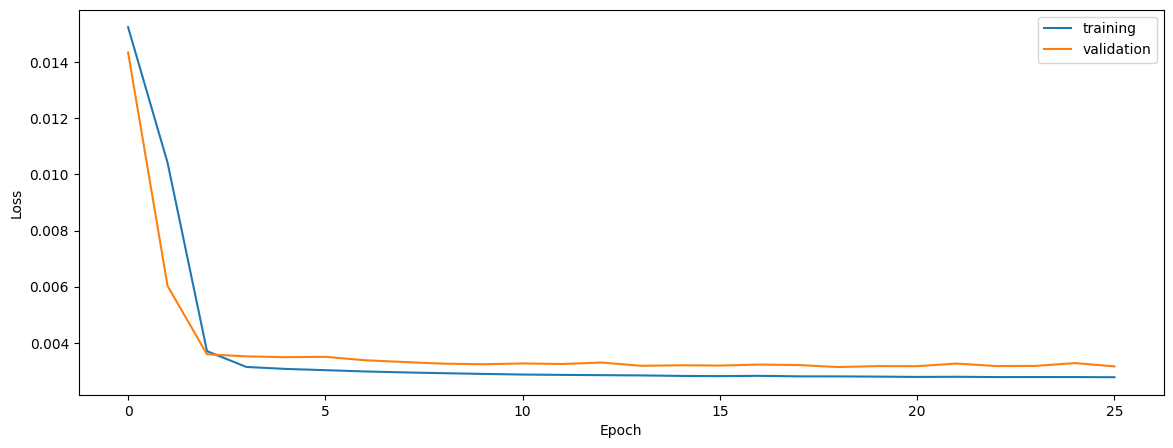

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8764862867734775
0.8857750078569839
0.8873987483321215


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.8764862867734775
0.8857750078569839
0.8873987483321215


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.880624762555518
0.8980549893357829
0.9013024028200937


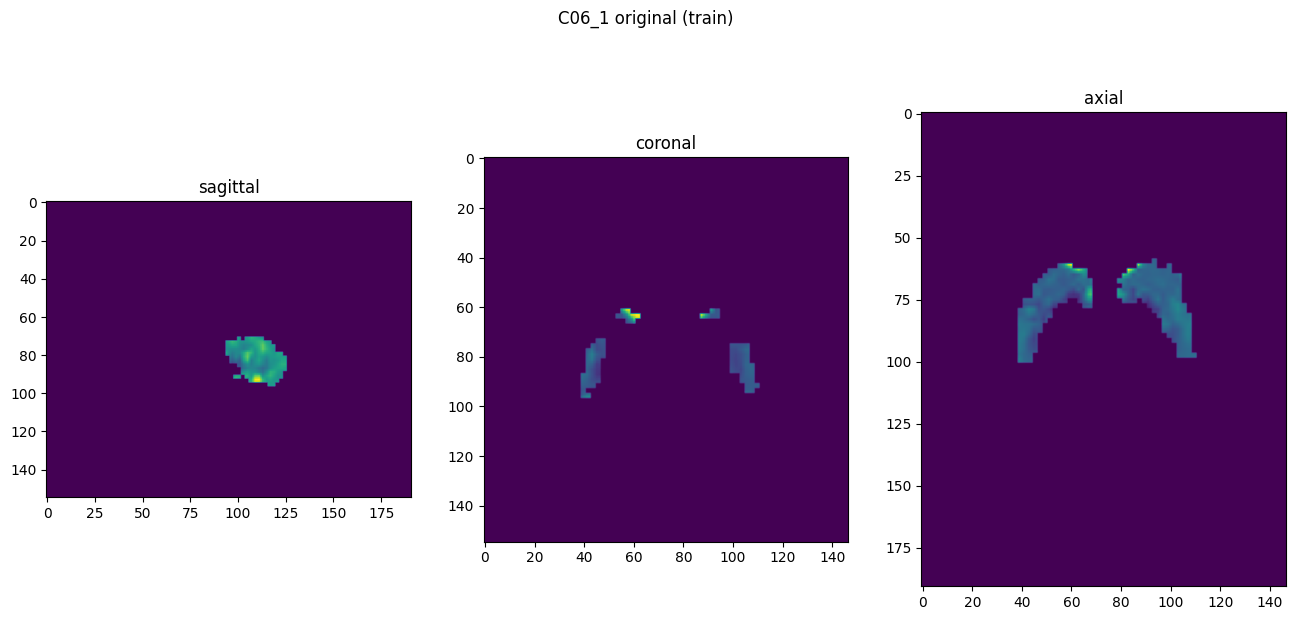

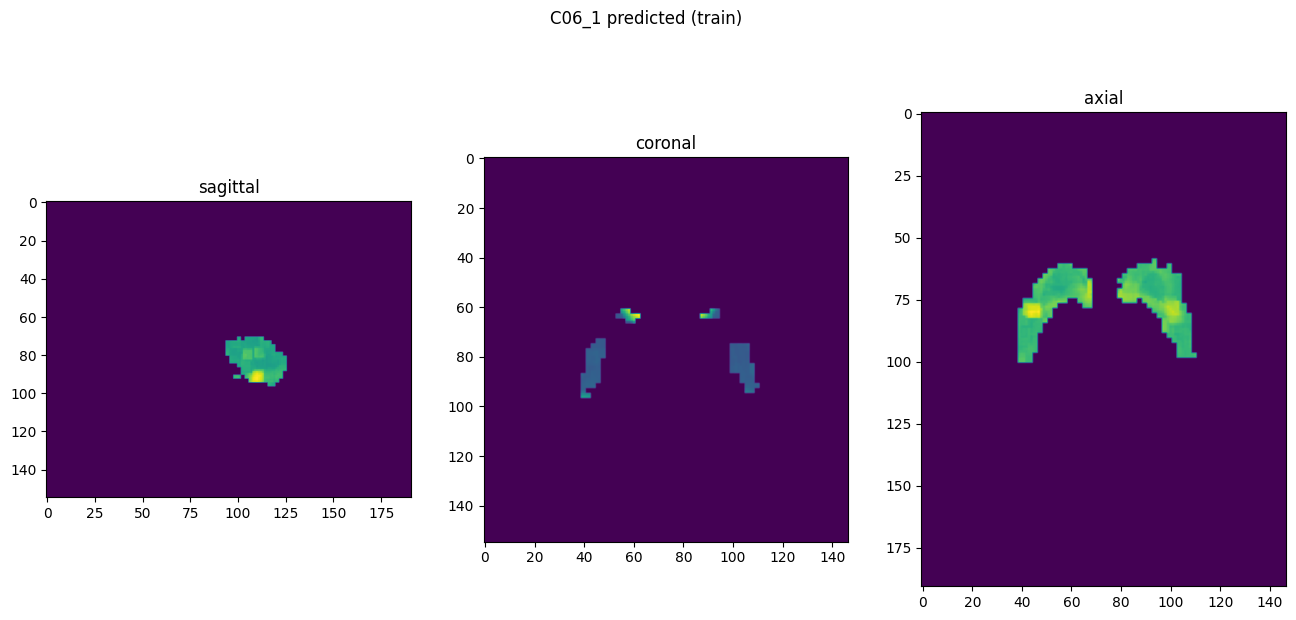

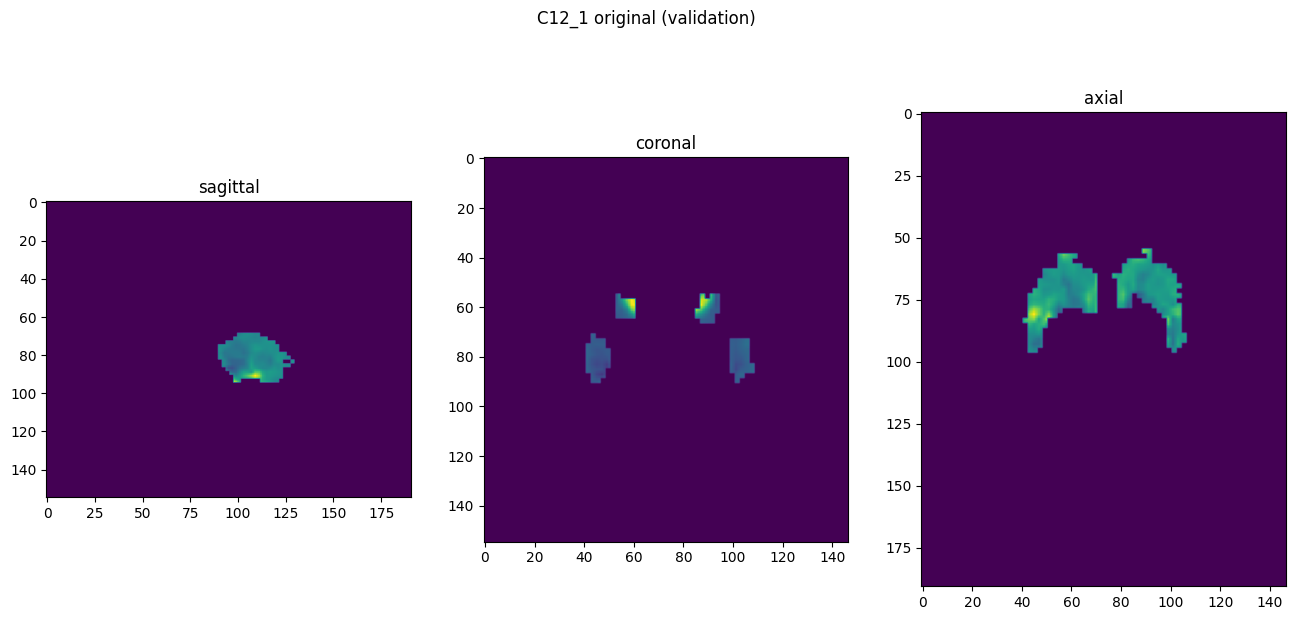

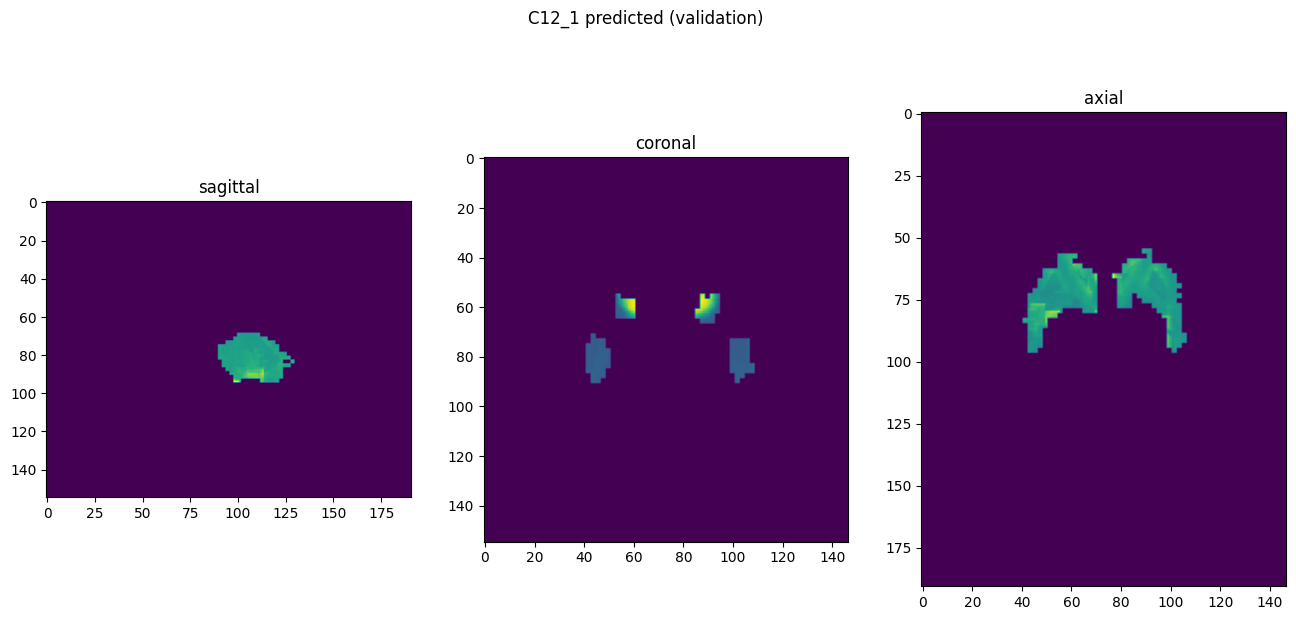

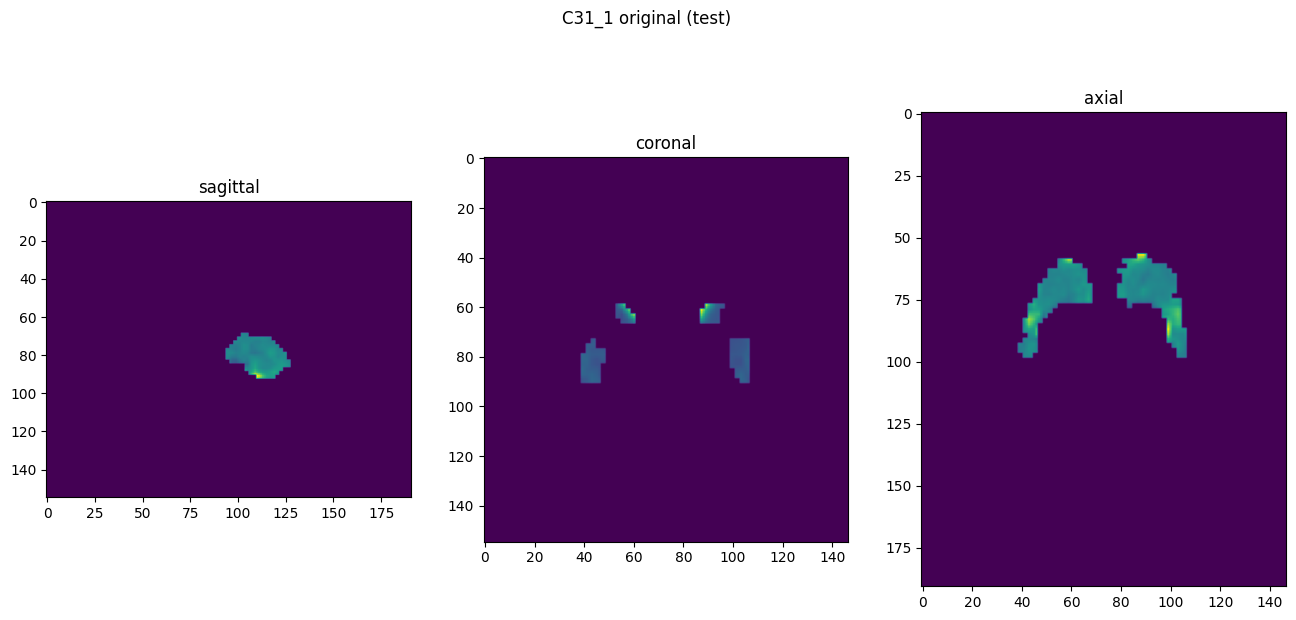

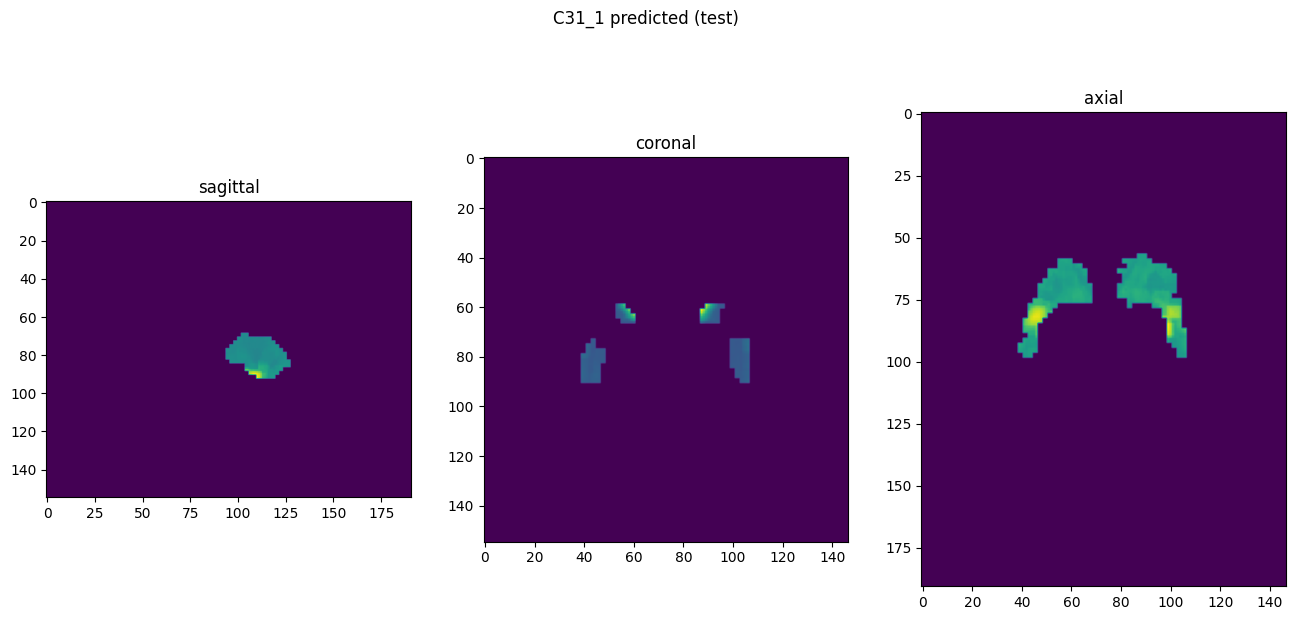

In [10]:
showResults(model, gen, threshold=None, background=False)